**CS22_2_PFC**

# Libraries

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import triku as tk

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.8 anndata==0.9.2 umap==0.5.3 numpy==1.24.4 scipy==1.8.0 pandas==1.2.4 scikit-learn==1.1.1 statsmodels==0.13.2 igraph==0.9.10 pynndescent==0.5.7


In [3]:
results_file = '/group/testa/Project/CBOProgPools/h5ad/CS22_02_20240208_v1.h5ad'  # the file that will store the analysis results

In [4]:
geschwind_ext = {
  'astrocytes' : ['S100B','AQP4'],
  'pericyte' : ['RGS5'],
  'microglia' : ['AIF1'],
  'endothelial' : ['ITM2A','CLDN5','ESAM'],
  'ExcDeepLayer' : ['SOX5'],
  'Interneurons' : ['DLX1','DLX2','DLX5'],
  'MatUpperEnr' : ['STMN2','SATB2','LMO4'],
  'IP' : ['PPP1R17','SSTR2','EOMES','PENK'],
  'MatExc' : ['SATB2','STMN2'],
  'MigExc' : ['POU3F2'],
  'CycProg' : ['HMGB2','SOX2','MKI67','PCNA'],
  'OPCs' : ['PTPRZ1','OLIG1','PDGFRA'],
  'RG' : ['VIM','PTPRZ1','SOX2','SLC1A3','HES1','HOPX'],
  'Exc_CAMK2A+' : ['CAMK2A'],
  'Exc_TBR1+' : ['TBR1']
}

In [5]:
# Read in the count matrix into an AnnData object, which holds many slots for annotations and different representations
# of the data. It also comes with its own HDF5-based file format: .h5ad.
adata = sc.read_10x_mtx(
    '/group/testa/Project/CBOProgPools/data/CS22_2_PFC/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/group-testa-Project-CBOProgPools-data-CS22_2_PFC-matrix.h5ad


In [6]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [7]:
adata

AnnData object with n_obs × n_vars = 621 × 33694
    var: 'gene_ids'

# Data Preparation

normalizing counts per cell
    finished (0:00:00)


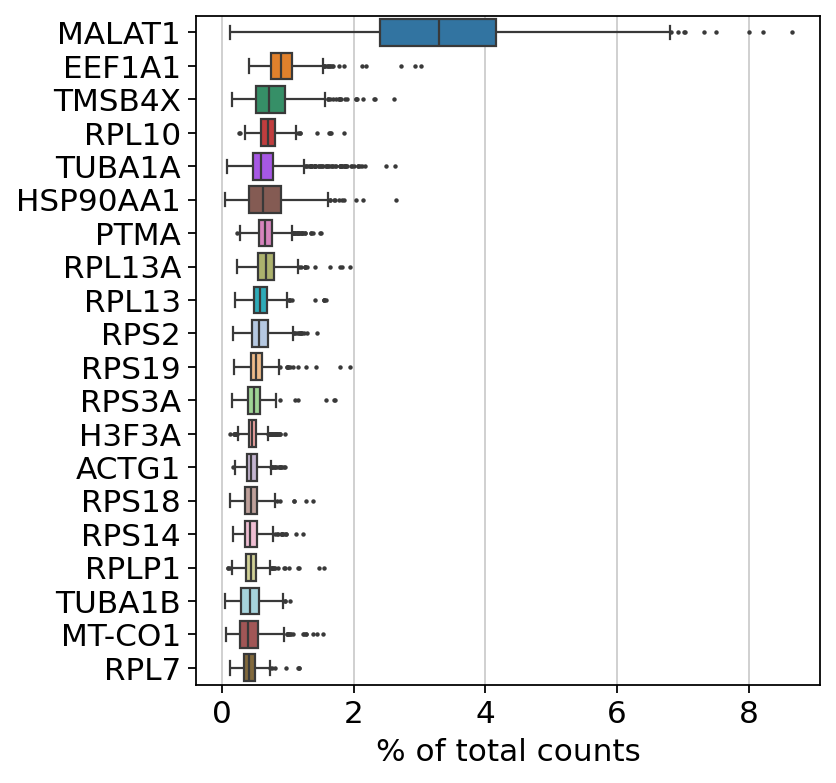

In [8]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20, )


In [9]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=50)

filtered out 22516 genes that are detected in less than 50 cells


In [10]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adata.var['ribo'] = adata.var_names.str.startswith('RPL')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)

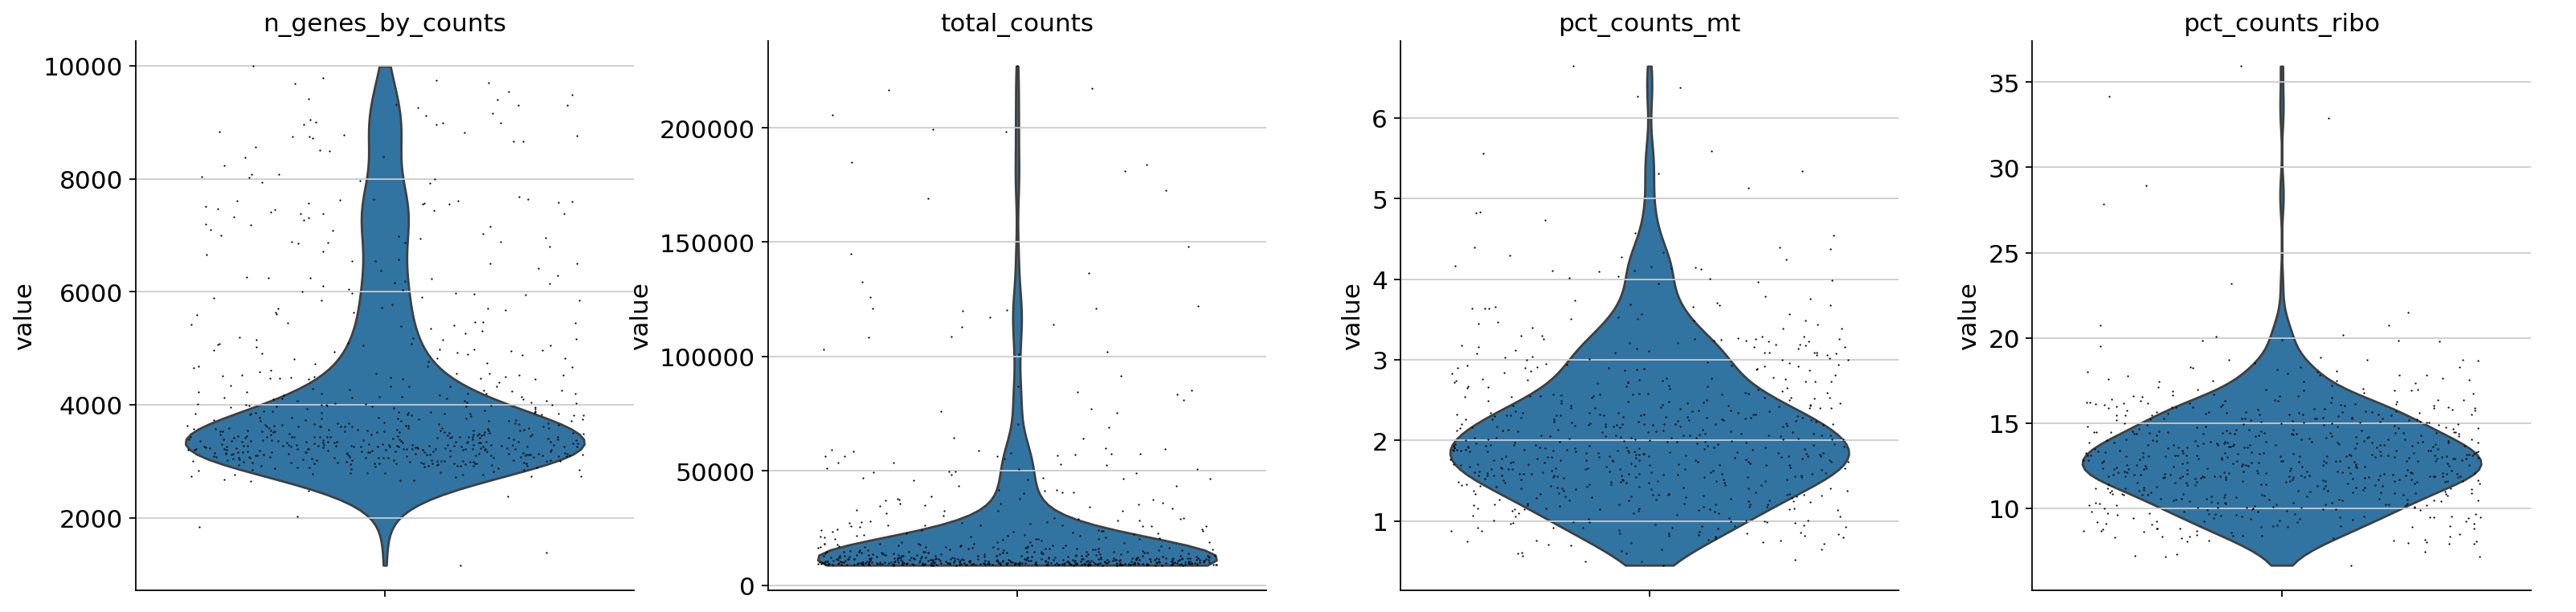

In [11]:
# A violin plot of some of the computed quality measures:
   # the number of genes expressed in the count matrix
   # the total counts per cell
   # the percentage of counts in mitochondrial genes

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],
             jitter=0.4, multi_panel=True)

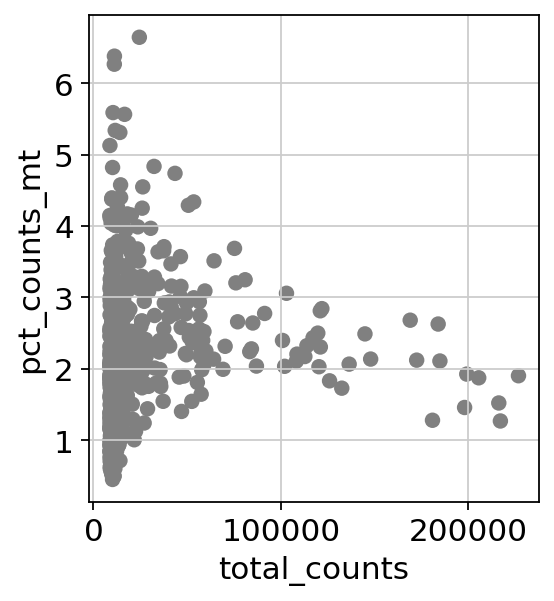

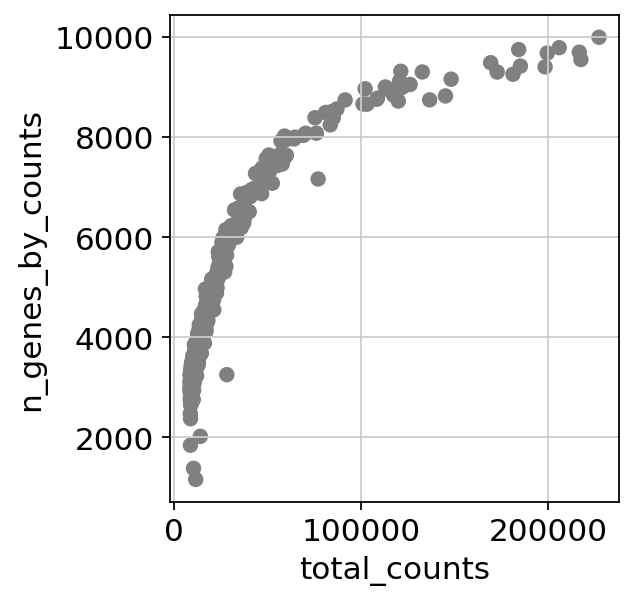

In [12]:
# Remove cells that have too many mitochondrial genes expressed or too many total counts:

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [13]:
adata = adata[adata.obs.total_counts <= 30000]

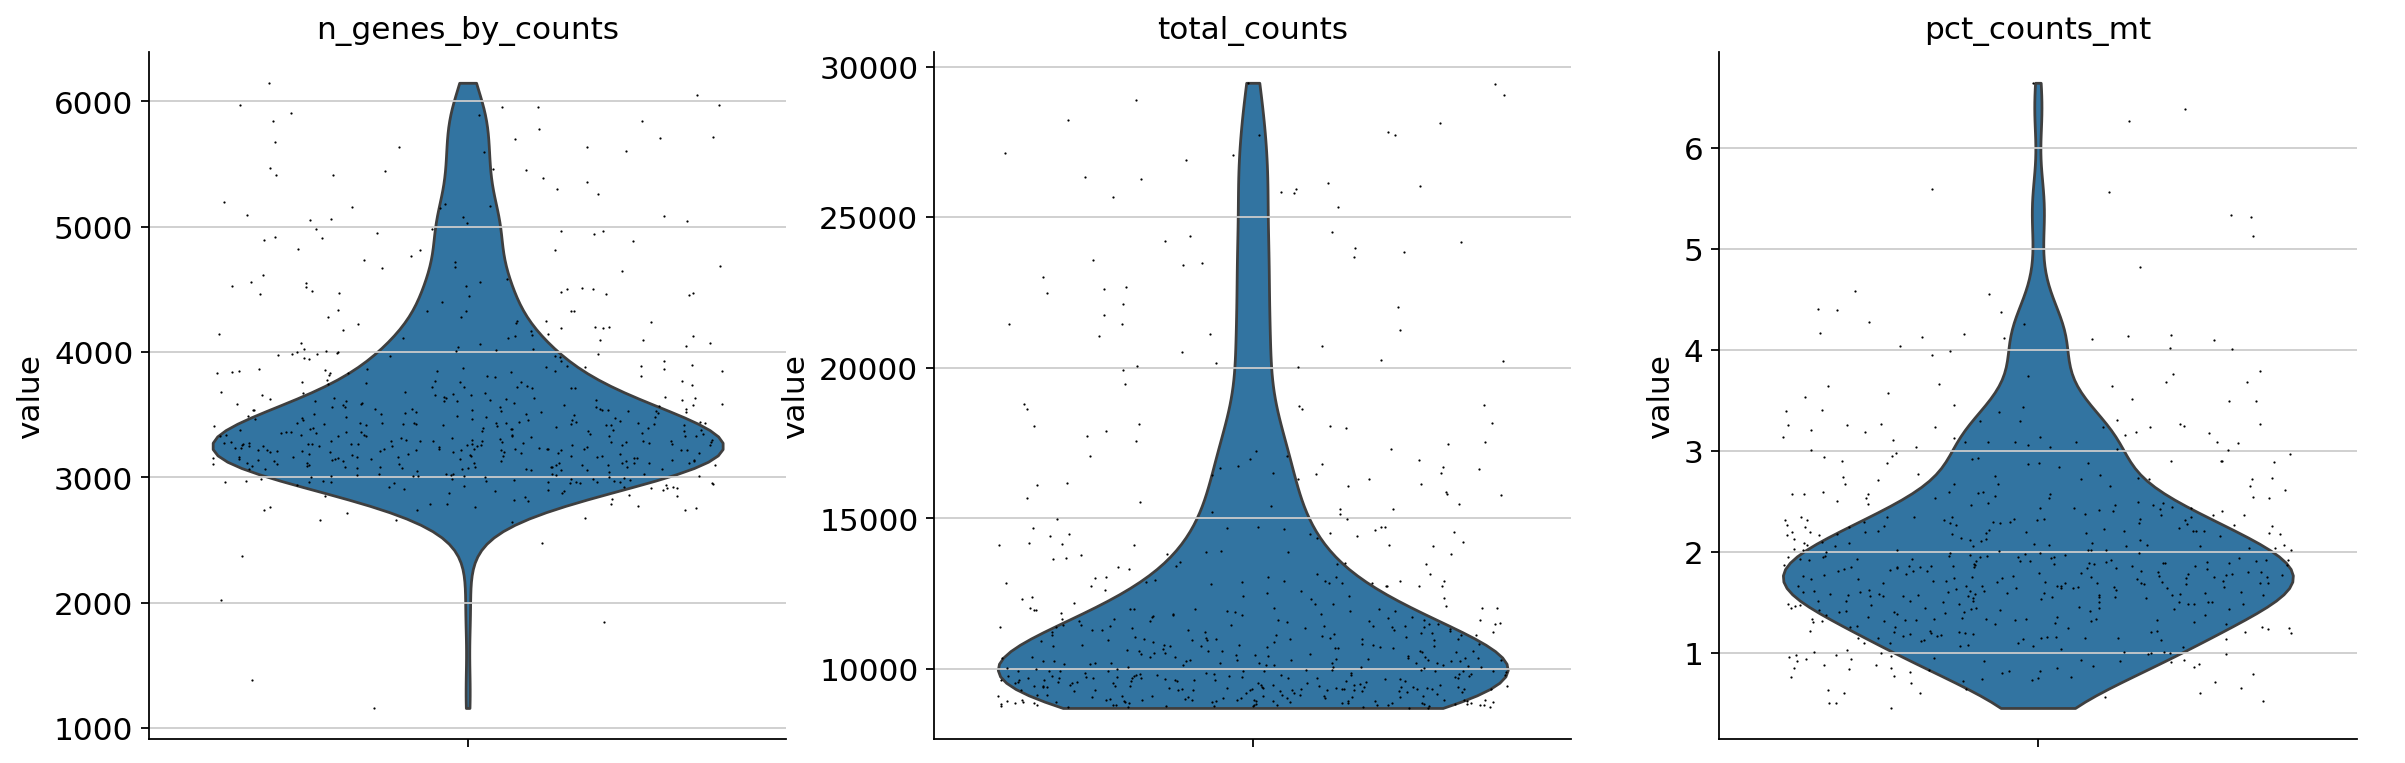

In [14]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

In [15]:
s_genes = pd.read_csv("/group/testa/Project/CBOProgPools/ReferenceFiles/S_genes",index_col=0,header=None)
g2m_genes = pd.read_csv("/group/testa/Project/CBOProgPools/ReferenceFiles/G2M_genes",index_col=0,header=None)
sc.tl.score_genes_cell_cycle(adata,s_genes.index,g2m_genes.index)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    599 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    425 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [16]:
adata.obs.keys()

Index(['n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score',
       'G2M_score', 'phase'],
      dtype='object')

In [17]:
adata.obs.phase.value_counts()

G1     264
G2M    217
S       38
Name: phase, dtype: int64

In [18]:
sc.external.pp.scrublet(adata)

Running Scrublet
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.27
Detected doublet rate = 1.7%
Estimated detectable doublet fraction = 9.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 18.9%
    Scrublet finished (0:00:01)


In [19]:
adata.obs.predicted_doublet.value_counts()

False    510
True       9
Name: predicted_doublet, dtype: int64

In [20]:
adata.raw = adata.copy()
adata.layers['Raw'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=30000) # highest meaningful coverage (see tot_counts)
adata.layers['normalized'] = adata.X.copy()
sc.pp.log1p(adata)
adata.layers['logNorm'] = adata.X.copy()

normalizing counts per cell
    finished (0:00:00)


In [21]:
adata

AnnData object with n_obs × n_vars = 519 × 11178
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo'
    uns: 'scrublet', 'log1p'
    layers: 'Raw', 'normalized', 'logNorm'

In [22]:
sc.pp.pca(adata, use_highly_variable=False)

sc.pp.neighbors(adata, metric='cosine', n_neighbors=int(0.5 * len(adata) ** 0.5)) #25 , 50. 75, 100
 
## Triku

tk.tl.triku(adata, use_raw=False)

Top20Triku = adata.var.sort_values(by=['triku_distance'], ascending=False).head(20).index
Top20Triku

computing PCA
    with n_comps=50
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)


Index(['RSPO1', 'CLDN3', 'KRT8', 'LHX5', 'LHX5-AS1', 'WNT8B', 'LHX1', 'SLA',
       'RELN', 'GJA1', 'AF003625.3', 'ARPP21', 'RBMS1', 'SAMD15', 'FGF14',
       'CTD-3064C13.1', 'MGST1', 'FGF17', 'NEUROD2', 'FXYD7'],
      dtype='object')

In [23]:
adata.var_names[adata.var['highly_variable'] == True]

Index(['RP11-54O7.17', 'ISG15', 'ACAP3', 'MXRA8', 'HES5', 'RP3-395M20.12',
       'RP13-436F16.1', 'LINC00982', 'PRDM16', 'AGTRAP',
       ...
       'MAPK8IP2', 'CXADR', 'TCP10L', 'C21orf59', 'CHAF1B', 'PCP4', 'RSPH1',
       'COL18A1', 'C21orf58', 'S100B'],
      dtype='object', length=873)

# Principle Component Analysis

In [24]:
# Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main 
# axes of variation and denoises the data.
sc.tl.pca(adata, svd_solver='arpack',use_highly_variable=True)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


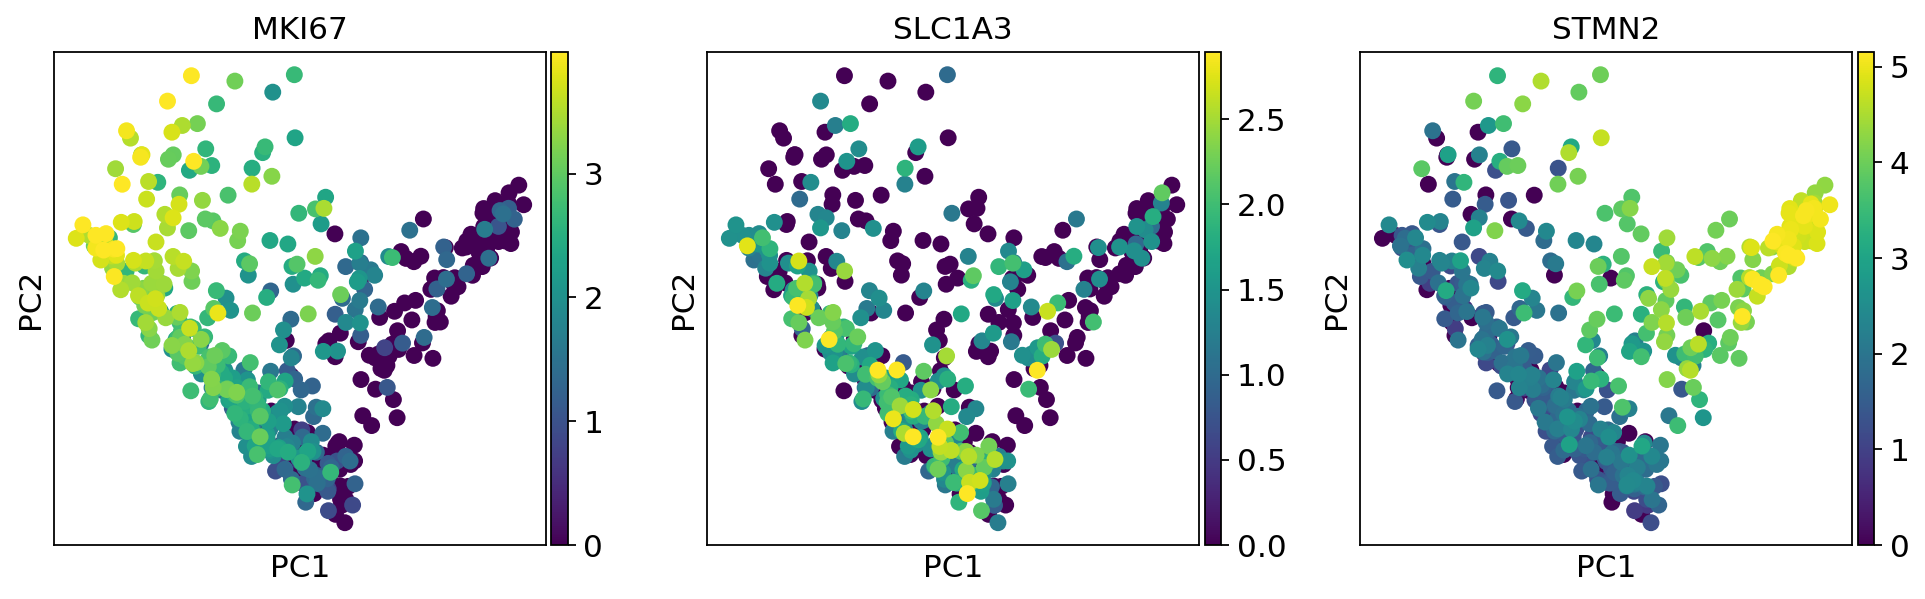

In [25]:
# We can make a scatter plot in the PCA coordinates, but we will not use that later on.

# MKI67 = cycling cell (usually progenitors, aRG / bRG / IP)
# EOMES = IP specific
# SLC1A3 = Radial Glia in general, including glia
# HOPX = bRG specific
# DCX = immature neurons
# STMN2 neurons in general

sc.pl.pca(adata, color=['MKI67','SLC1A3','STMN2'],use_raw=False,vmin="p1",vmax="p99") 

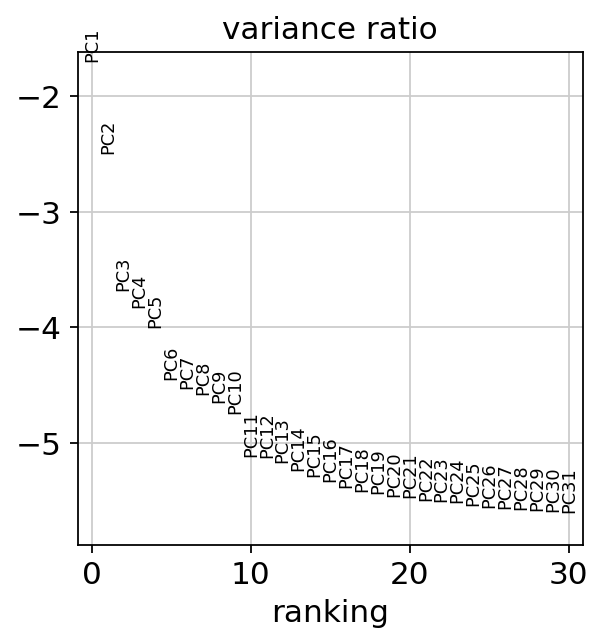

In [26]:
# Let us inspect the contribution of single PCs to the total variance in the data. 
# This gives us information about how many PCs we should consider in order to compute 
# the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() 
# or tSNE sc.tl.tsne(). In our experience, often a rough estimate of the number of PCs does fine.
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
# saving the result
adata.write(results_file)

In [28]:
adata

AnnData object with n_obs × n_vars = 519 × 11178
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo', 'highly_variable', 'triku_distance', 'triku_distance_uncorrected', 'triku_highly_variable'
    uns: 'scrublet', 'log1p', 'pca', 'neighbors', 'triku_params'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'Raw', 'normalized', 'logNorm'
    obsp: 'distances', 'connectivities'

# Computing Neighborhood Graph 

In [29]:
int(0.5 * len(adata) ** 0.5)

11

In [30]:
# Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. 
# You might simply use default values here. For the sake of reproducing Seurat’s results, let’s take the following values.
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


# Embedding Neighborhood Graph

In [31]:
sc.tl.leiden(adata,resolution=0.5,key_added="leiden")
# small resolution ==> less clusters 
# 0.4 - 1.5

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [32]:
adata.obs.leiden.value_counts()

0    121
1    111
2     87
3     62
4     40
5     37
6     34
7     27
Name: leiden, dtype: int64

In [33]:
# We suggest embedding the graph in two dimensions using UMAP (McInnes et al., 2018), see below. 
# It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it 
# better preserves trajectories. In some ocassions, you might still observe disconnected clusters and
# similar connectivity violations. They can usually be remedied by running:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


In [34]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


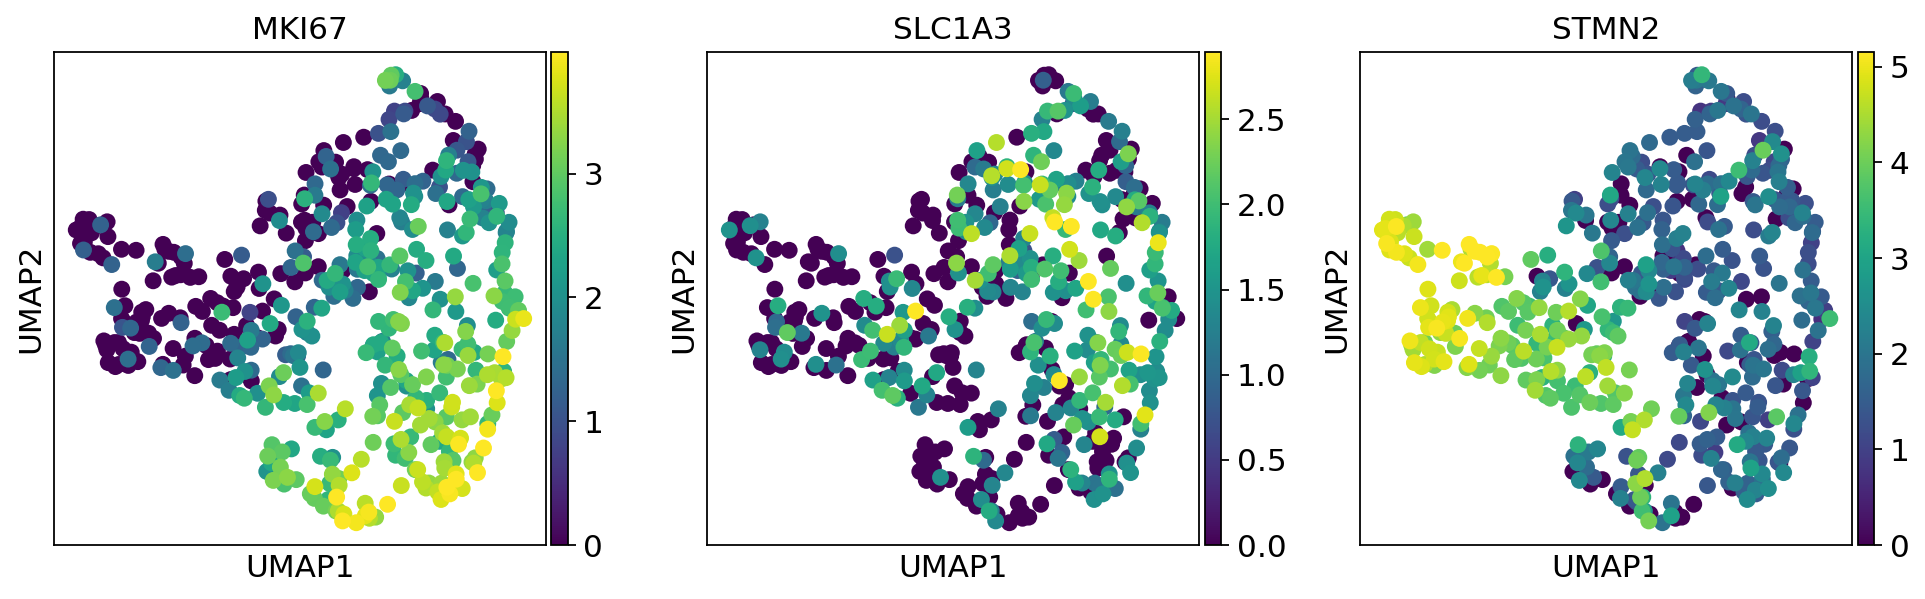

In [35]:
# As we set the .raw attribute of adata, the previous plots showed the “raw” (normalized, logarithmized, but uncorrected) 
# gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don’t want to 
# use .raw.
sc.pl.umap(adata, color=['MKI67','SLC1A3','STMN2'], use_raw=False,vmin="p1",vmax="p99")

# Clustering Neighborhood Graph

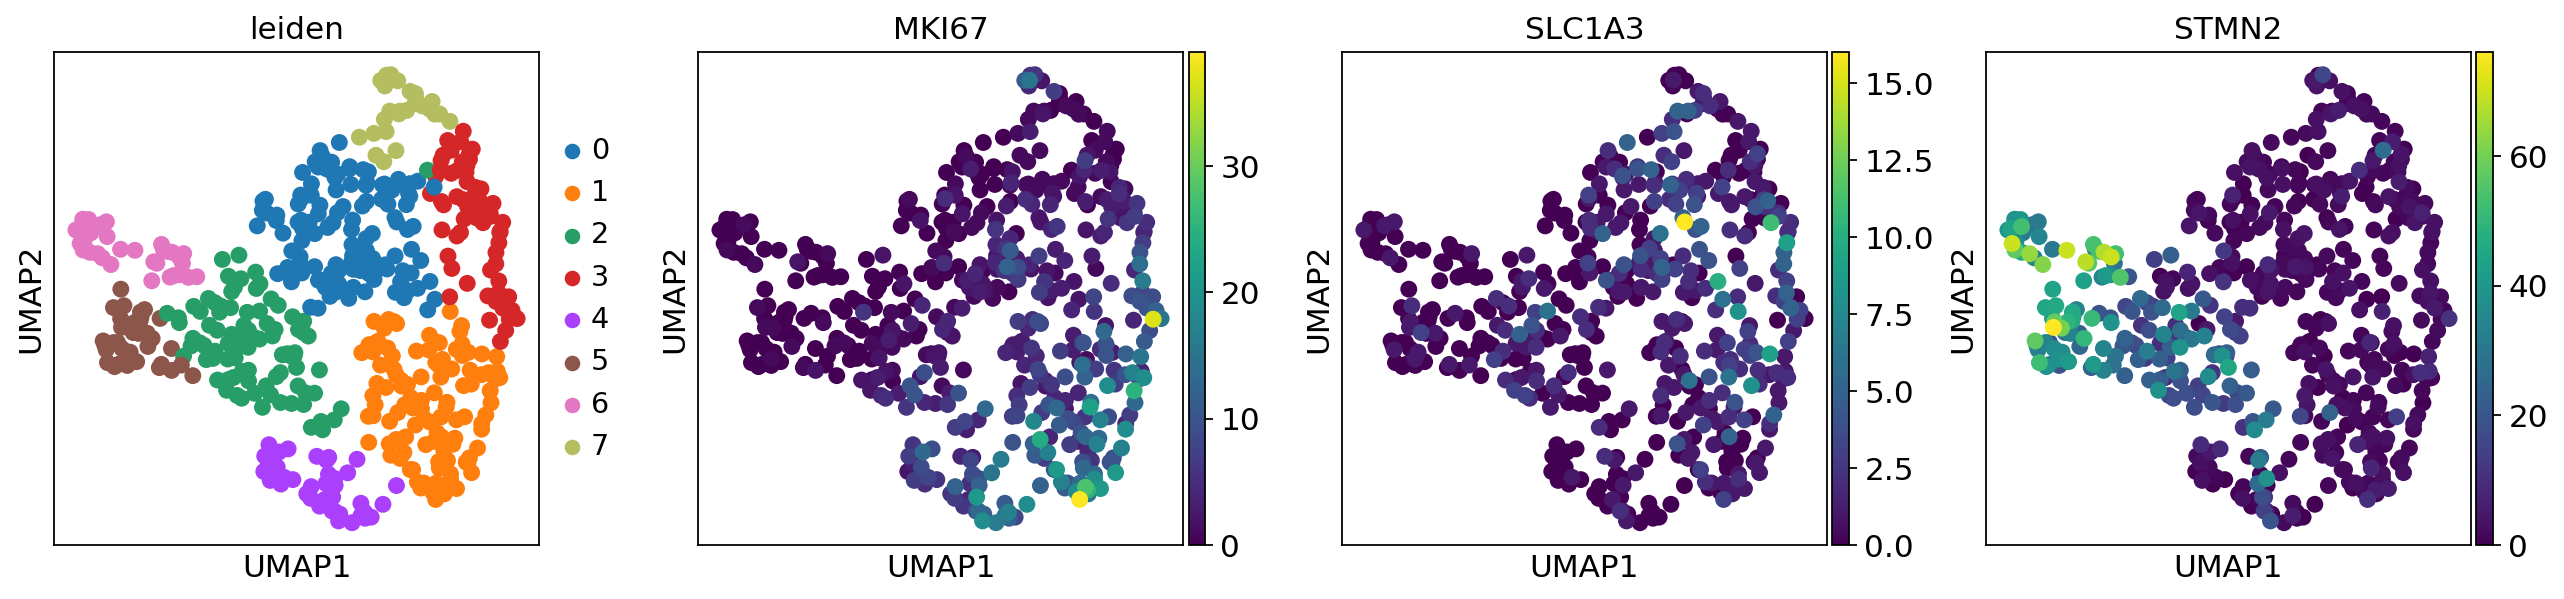

In [36]:
# Plot the clusters, which agree quite well with the result of Seurat.
sc.pl.umap(adata, color=['leiden', 'MKI67','SLC1A3','STMN2'])

In [ ]:
# saving results
adata.write(results_file)

# Finding Gene Markers

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


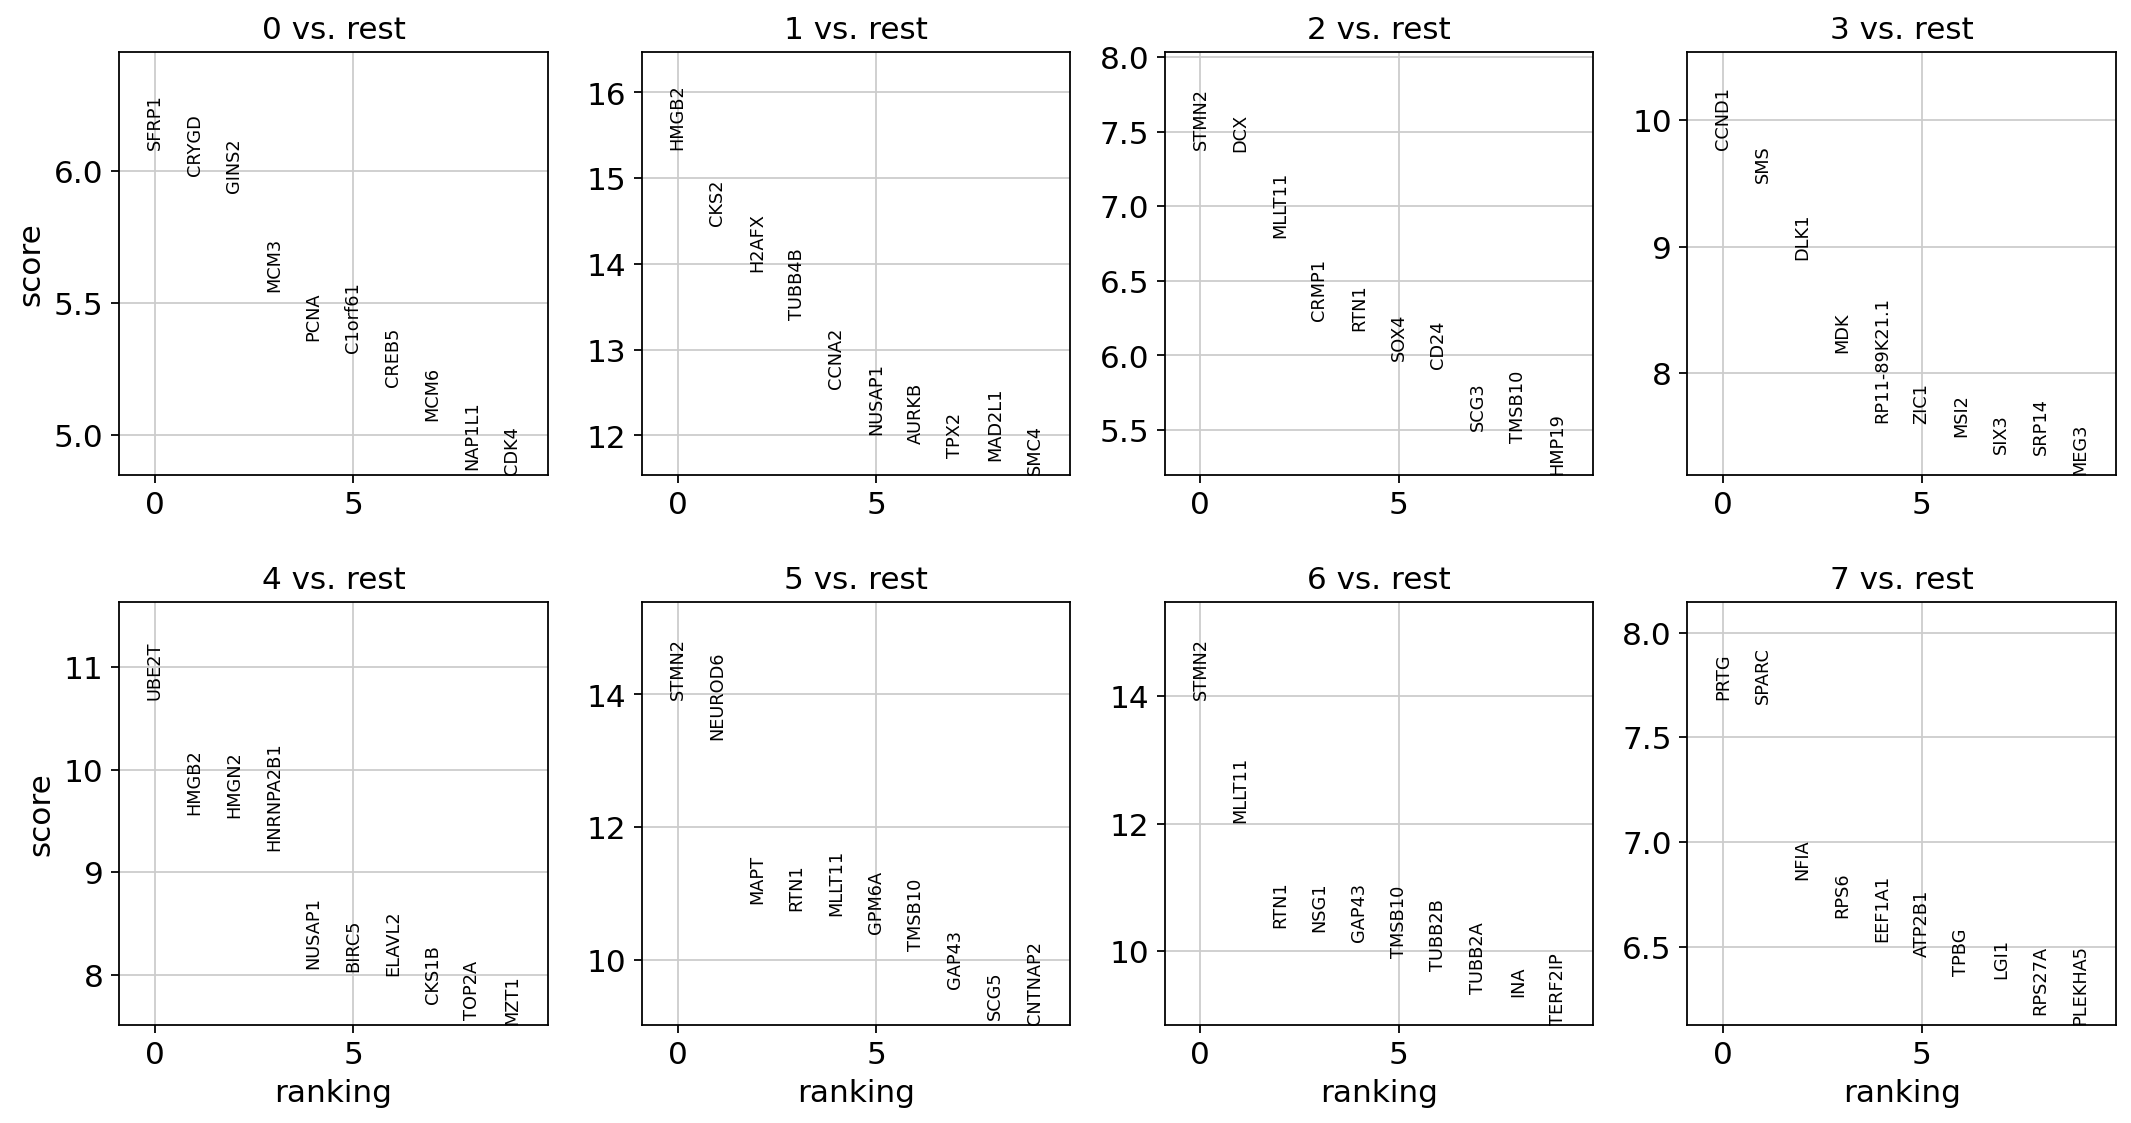

In [37]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

In [38]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n           0_p     1_n           1_p     2_n           2_p  \
0  SFRP1  6.168175e-09   HMGB2  5.514746e-33   STMN2  5.039056e-12   
1  CRYGD  1.575383e-08    CKS2  2.255386e-29     DCX  1.505797e-11   
2  GINS2  1.779016e-08   H2AFX  9.049567e-29  MLLT11  2.043495e-10   
3   MCM3  9.296592e-08  TUBB4B  1.679821e-26   CRMP1  4.825689e-09   
4   PCNA  2.523365e-07   CCNA2  1.871215e-24    RTN1  4.248546e-09   

            3_n           3_p        4_n           4_p      5_n           5_p  \
0         CCND1  2.768009e-14      UBE2T  1.158290e-13    STMN2  1.651305e-17   
1           SMS  7.579246e-14      HMGB2  5.834040e-13  NEUROD6  1.234847e-15   
2          DLK1  1.210396e-12      HMGN2  1.571434e-12     MAPT  1.896127e-13   
3           MDK  1.577376e-11  HNRNPA2B1  7.125610e-12     RTN1  3.652421e-13   
4  RP11-89K21.1  1.829062e-10     NUSAP1  1.498228e-10   MLLT11  8.204770e-14   

      6_n           6_p     7_n           7_p  
0   STMN2  3.587634e-16    PRTG  3.651940e-08  
1  MLLT11  2.471182e-14   SPARC  2.723674e-08  
2    RTN1  2.474746e-12    NFIA  2.509449e-07  
3    NSG1  2.915925e-12    RPS6  3.362894e-07  
4   GAP43  5.163435e-12  EEF1A1  5.401807e-07

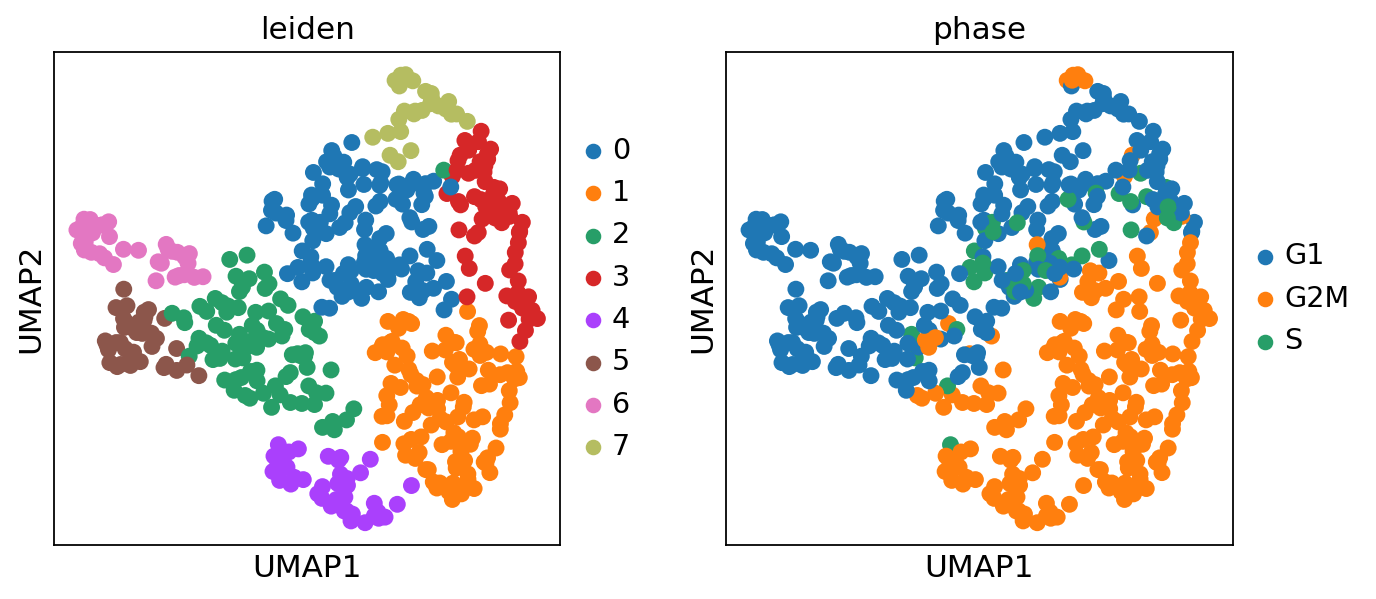

In [41]:
sc.pl.umap(adata,color=["leiden","phase"])

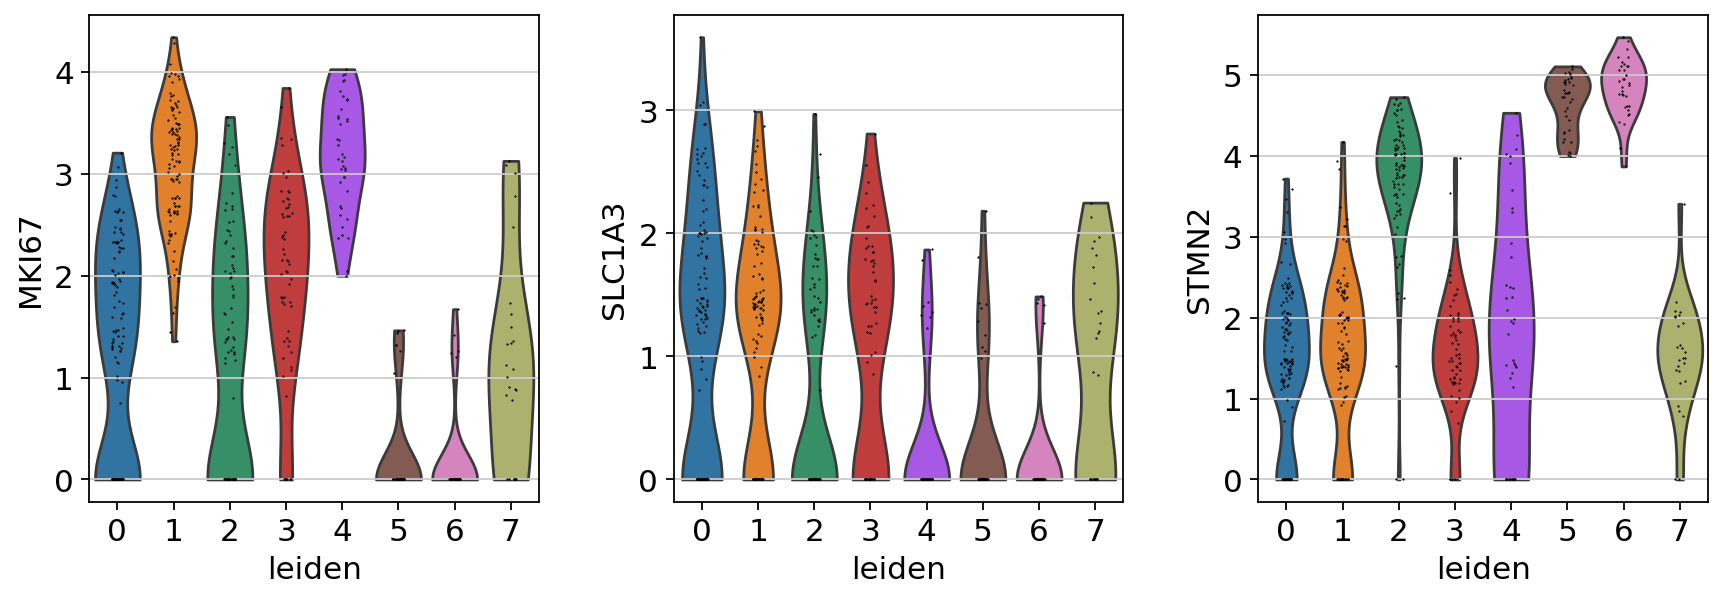

In [42]:
sc.pl.violin(adata, ['MKI67', 'SLC1A3','STMN2'], groupby='leiden',use_raw=False)

In [43]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

0       1       2             3          4        5        6        7
0    SFRP1   HMGB2   STMN2         CCND1      UBE2T    STMN2    STMN2     PRTG
1    CRYGD    CKS2     DCX           SMS      HMGB2  NEUROD6   MLLT11    SPARC
2    GINS2   H2AFX  MLLT11          DLK1      HMGN2     MAPT     RTN1     NFIA
3     MCM3  TUBB4B   CRMP1           MDK  HNRNPA2B1     RTN1     NSG1     RPS6
4     PCNA   CCNA2    RTN1  RP11-89K21.1     NUSAP1   MLLT11    GAP43   EEF1A1
5  C1orf61  NUSAP1    SOX4          ZIC1      BIRC5    GPM6A   TMSB10   ATP2B1
6    CREB5   AURKB    CD24          MSI2     ELAVL2   TMSB10   TUBB2B     TPBG
7     MCM6    TPX2    SCG3          SIX3      CKS1B    GAP43   TUBB2A     LGI1
8   NAP1L1  MAD2L1  TMSB10         SRP14      TOP2A     SCG5      INA   RPS27A
9     CDK4    SMC4   HMP19          MEG3       MZT1  CNTNAP2  TERF2IP  PLEKHA5

In [44]:

marker_genes = ['leiden','SFRP1', 'CRYGD','HMGB2','CKS2','STMN2','DCX','CCND1','SMS','UBE2T','HMGB2','MLLT11','PRTG','SPARC']


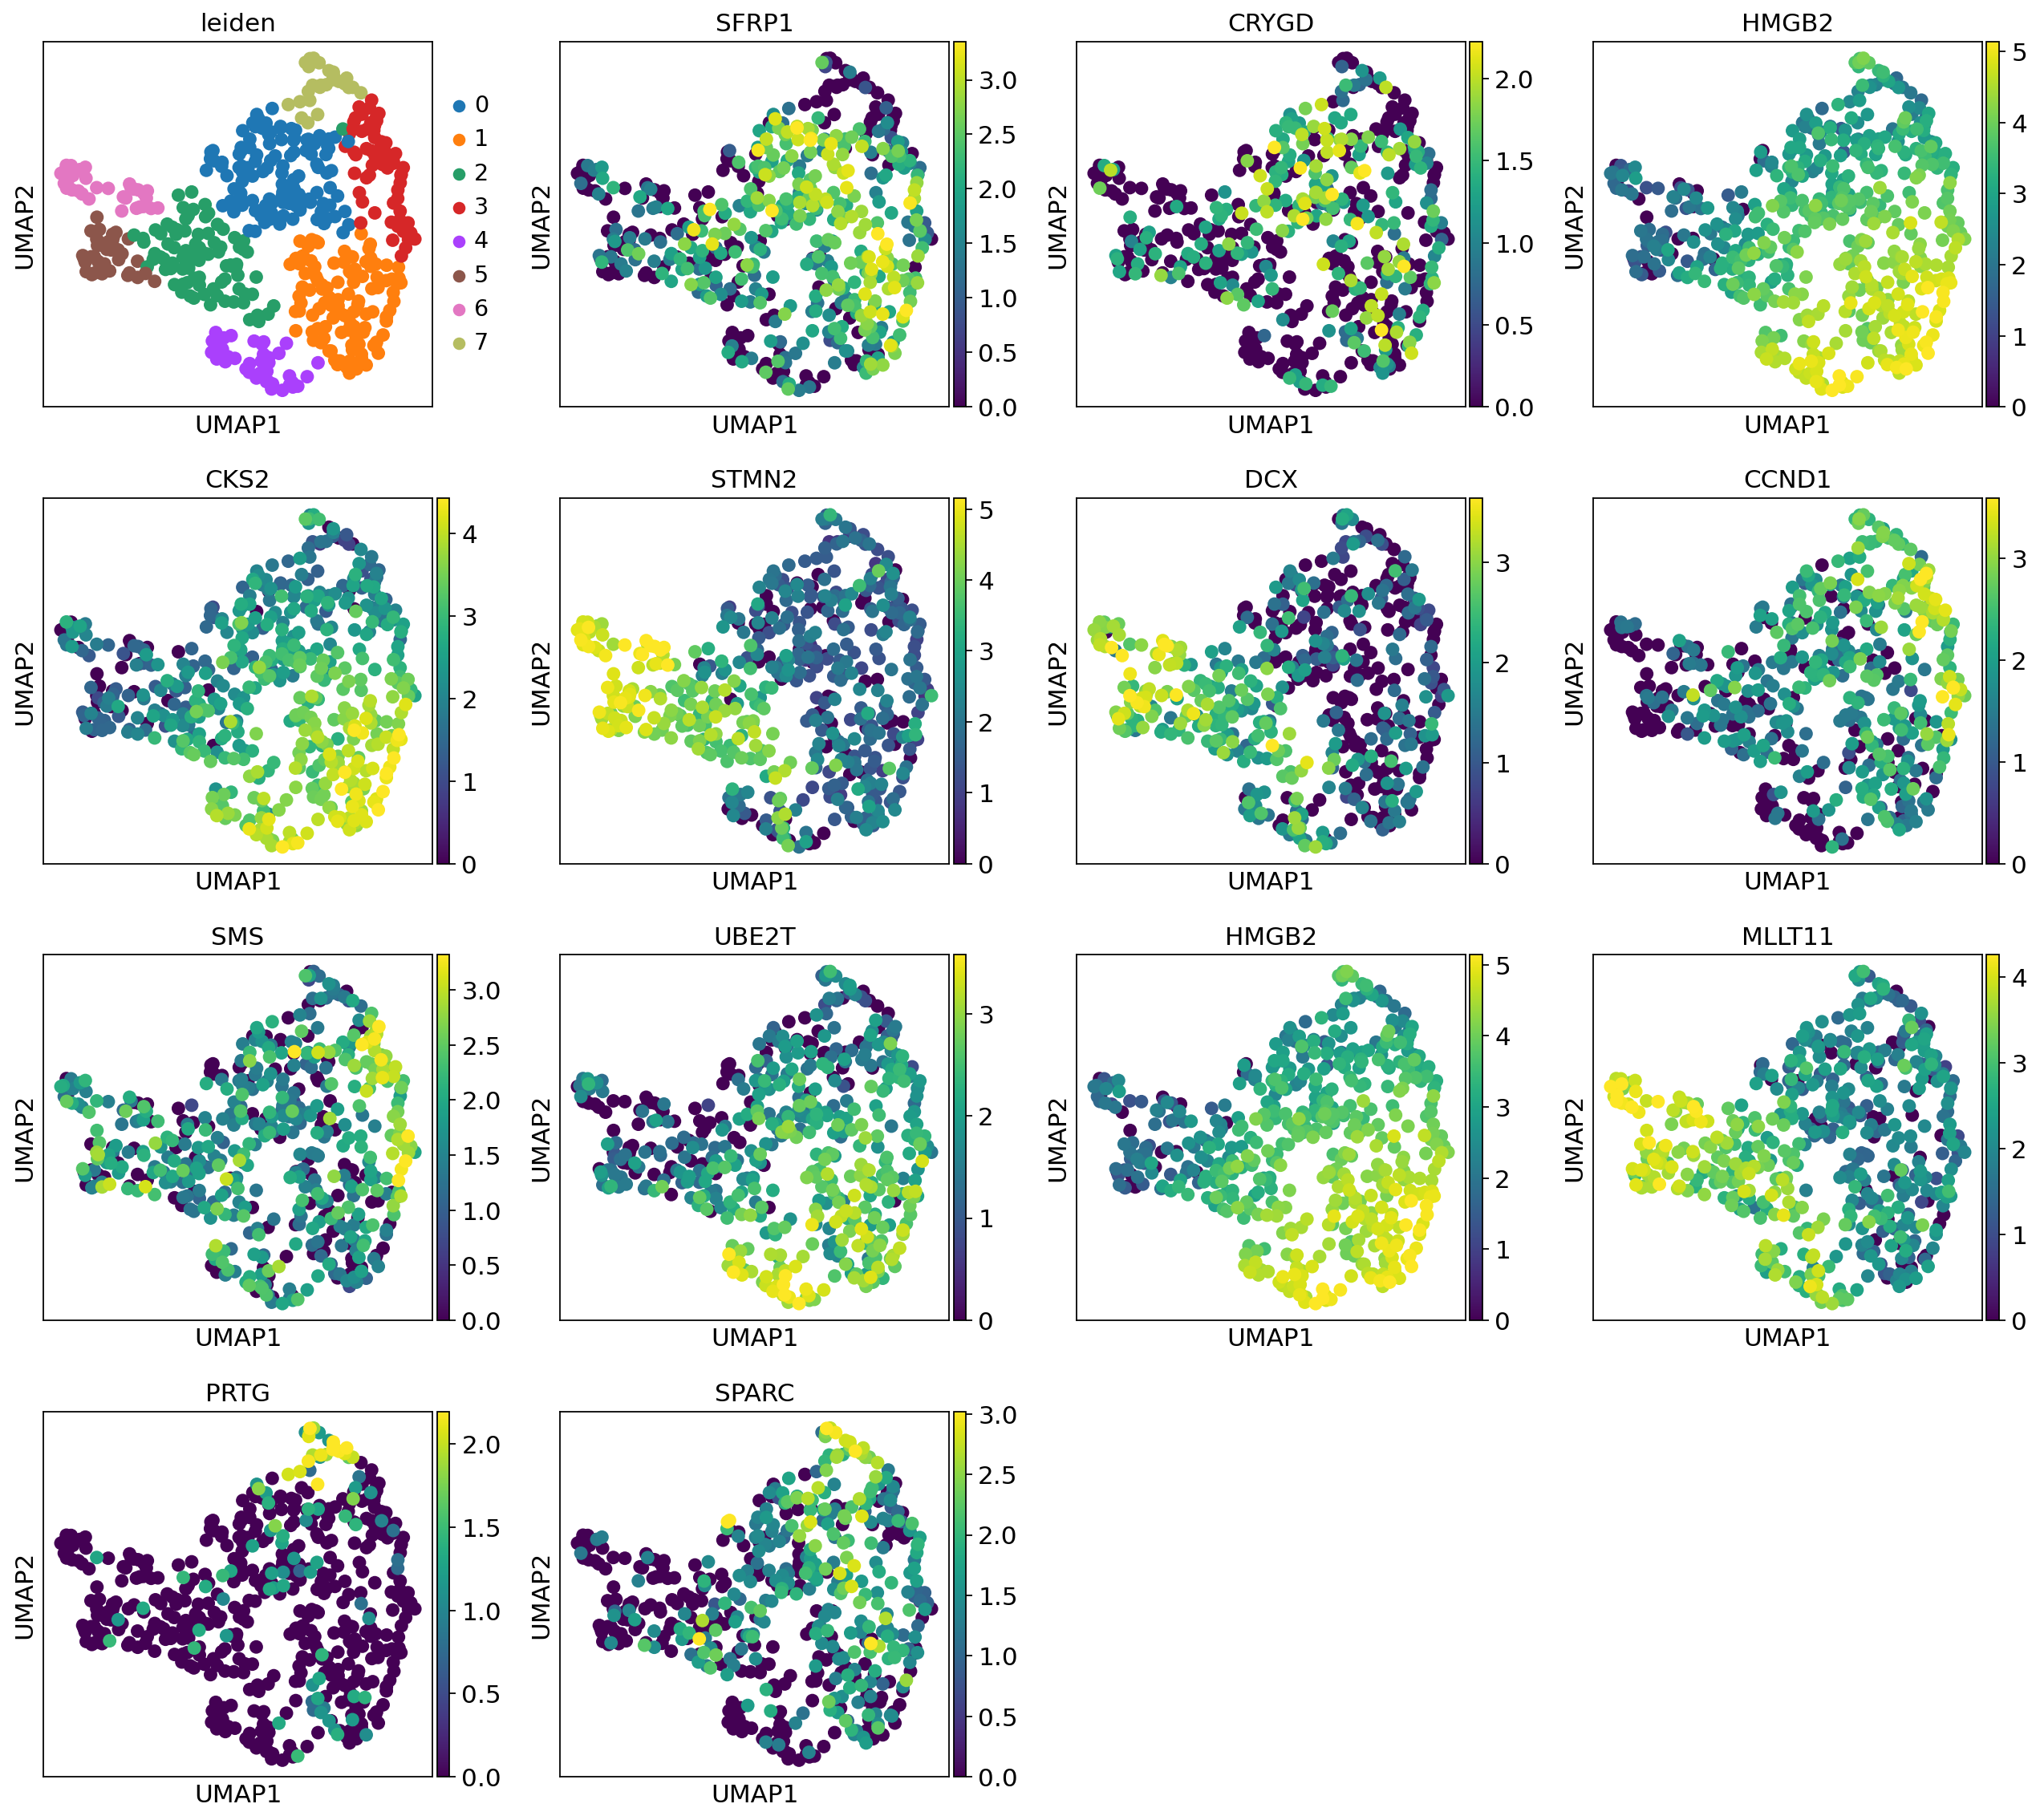

In [45]:
sc.pl.umap(adata,color=marker_genes,vmin="p1",vmax="p99",use_raw=False)

In [46]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9850708  0.9742822  0.9554046  0.95011204 0.94743186
     0.93991303 0.92338544 0.91397285 0.90914667 0.89508355 0.89061564
     0.88131887 0.87250364 0.86077774]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


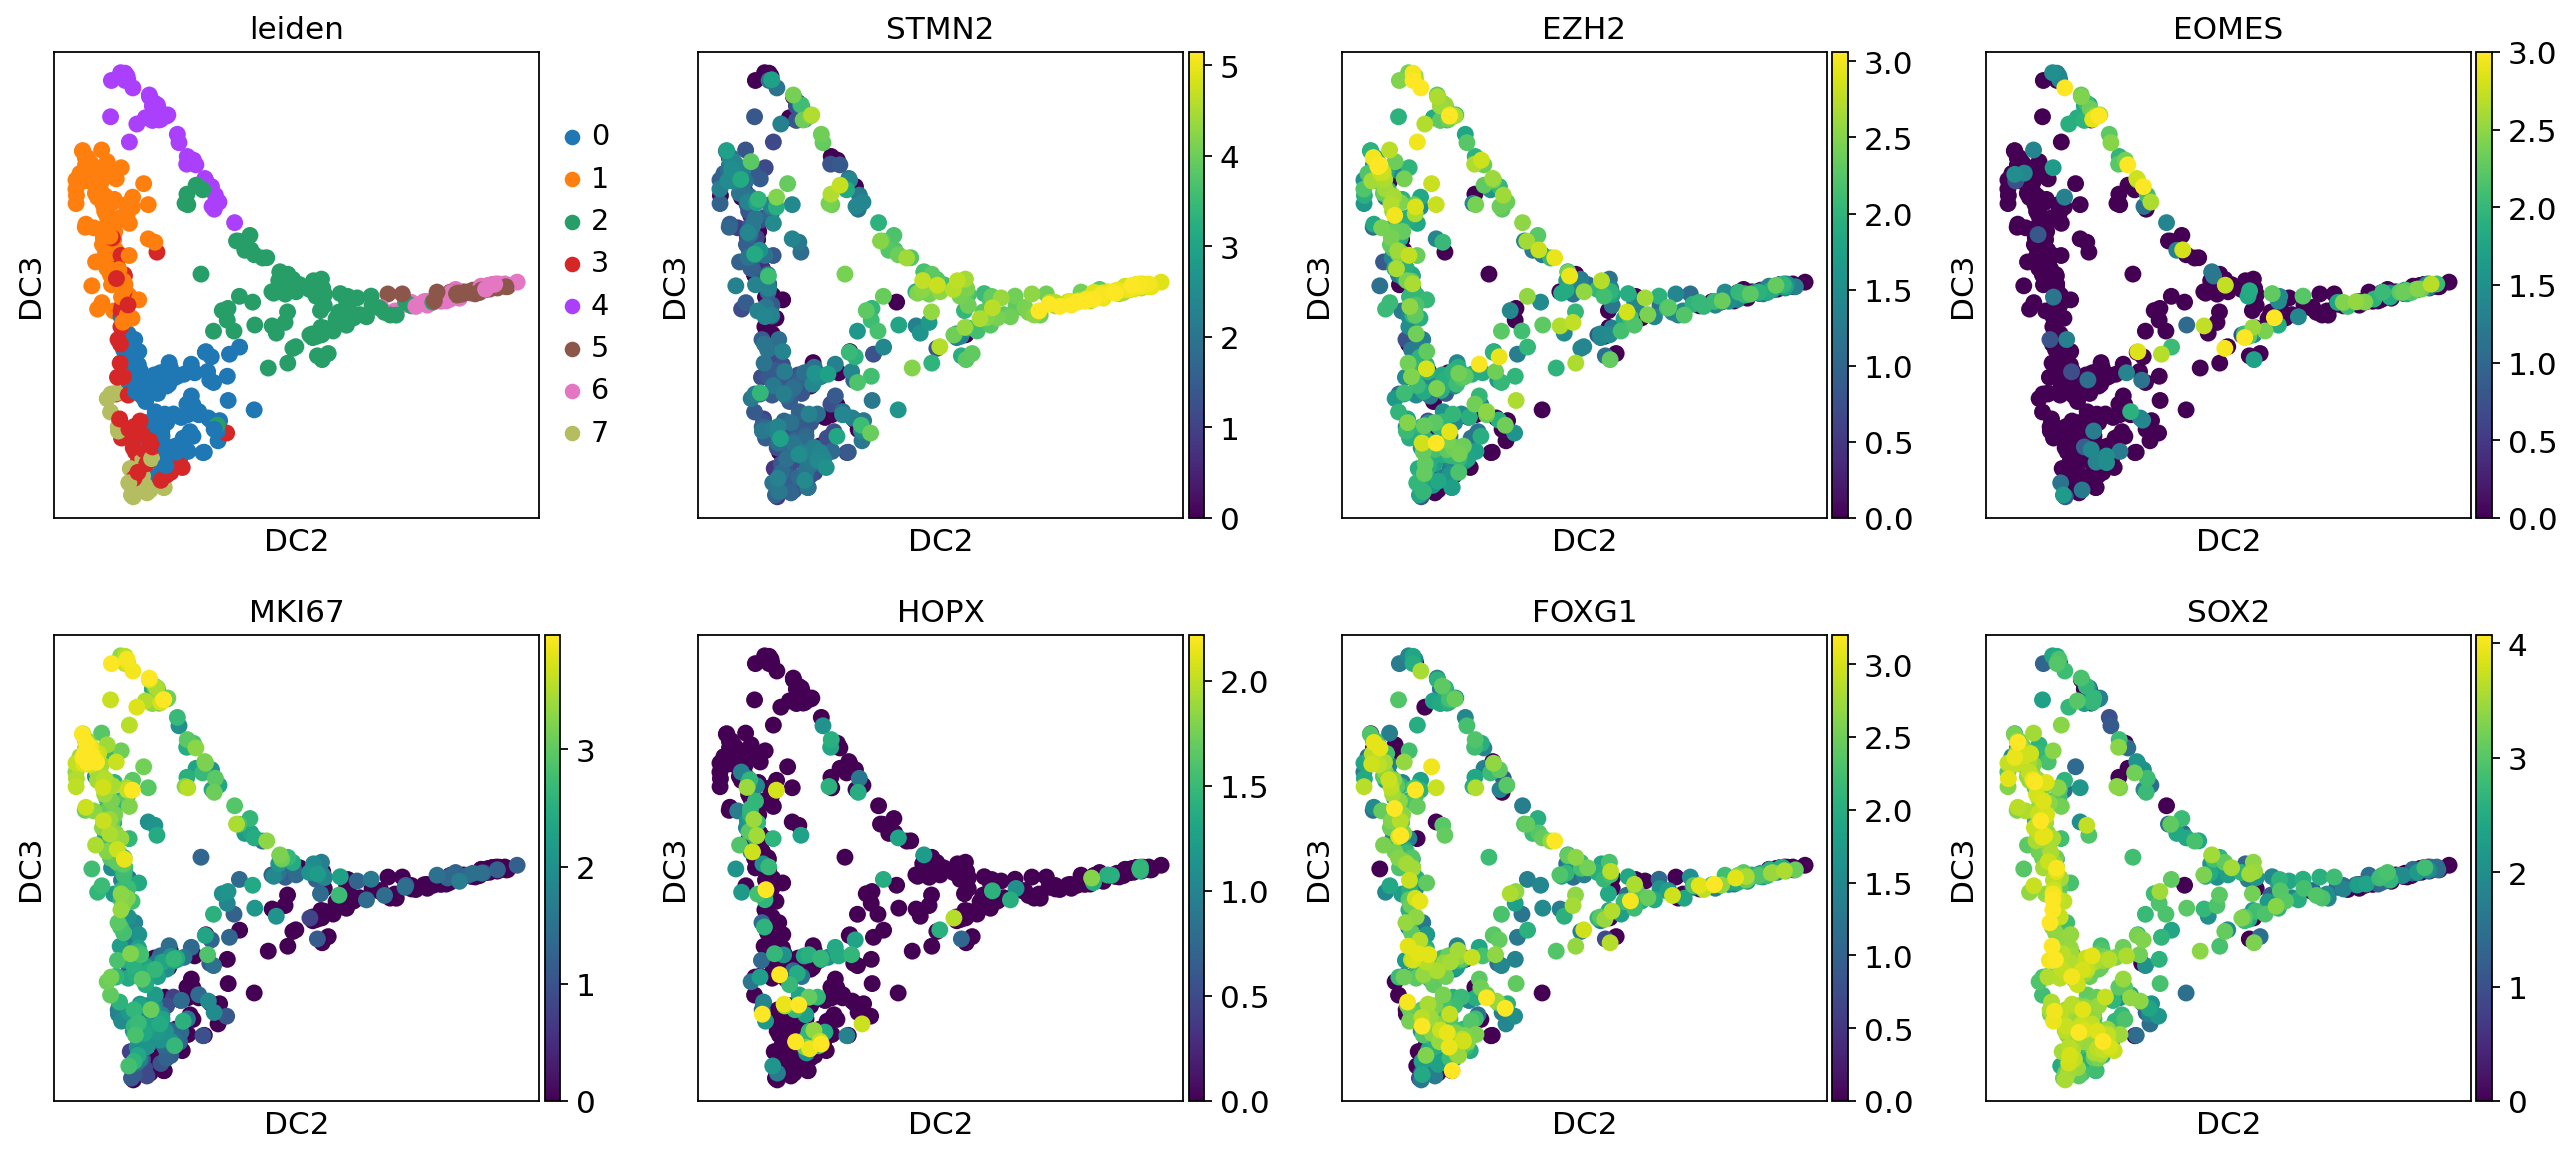

In [47]:
sc.pl.diffmap(adata,color=["leiden", 'STMN2','EZH2', 'EOMES', 'MKI67','HOPX','FOXG1','SOX2'],dimensions=(1,2),vmin='p1',vmax='p99',use_raw=False)

In [48]:
sc.tl.leiden(adata,resolution=0.5,key_added="leiden")

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: astrocytes, endothelial, ExcDeepLayer, etc.


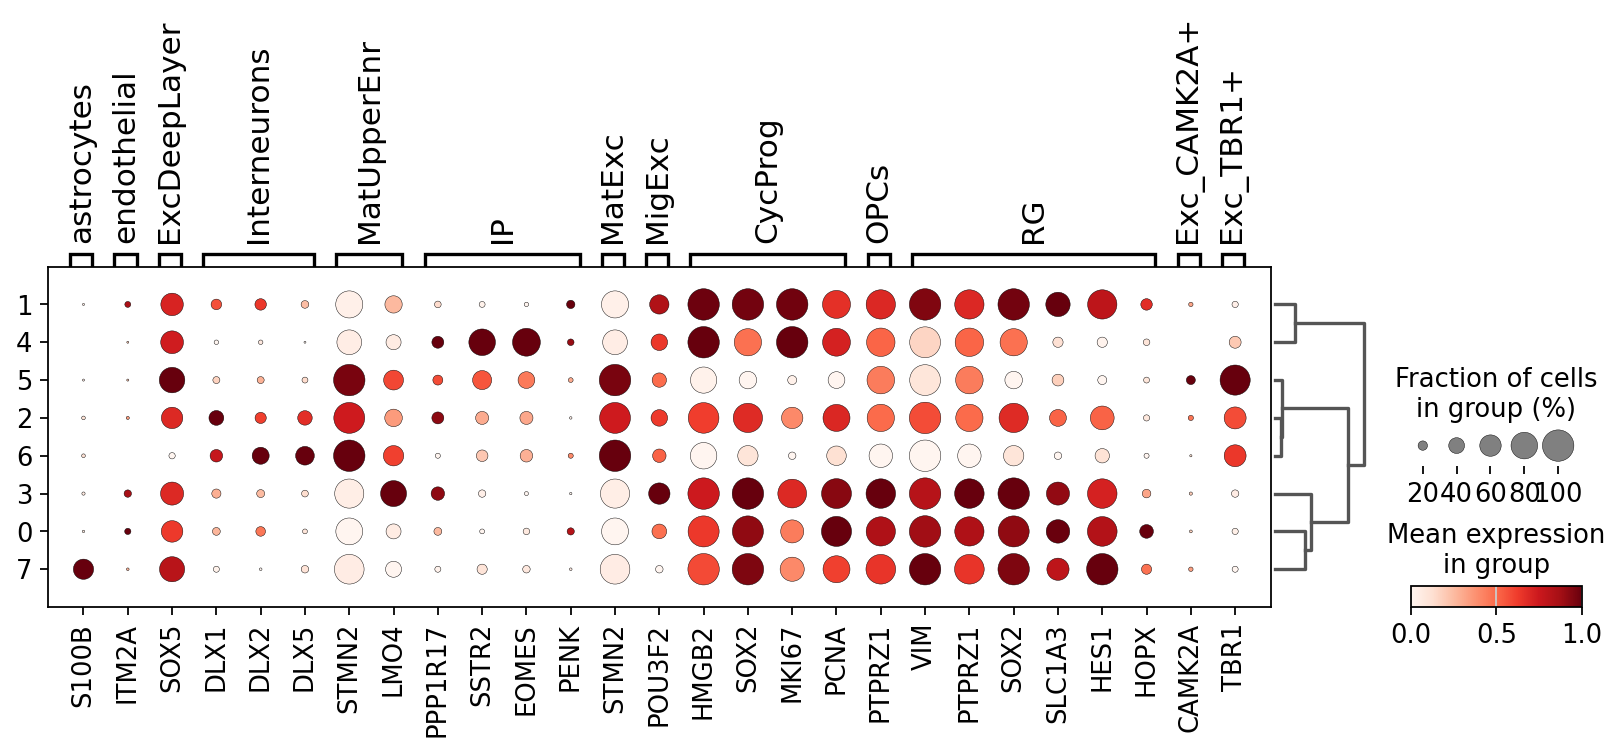

In [49]:
geschwind_ext = {
  'astrocytes' : ['S100B'],
  'endothelial' : ['ITM2A'],
  'ExcDeepLayer' : ['SOX5'],
  'Interneurons' : ['DLX1','DLX2','DLX5'],
  'MatUpperEnr' : ['STMN2','LMO4'],
  'IP' : ['PPP1R17','SSTR2','EOMES','PENK'],
  'MatExc' : ['STMN2'],
  'MigExc' : ['POU3F2'],
  'CycProg' : ['HMGB2','SOX2','MKI67','PCNA'],
  'OPCs' : ['PTPRZ1'],
  'RG' : ['VIM','PTPRZ1','SOX2','SLC1A3','HES1','HOPX'],
  'Exc_CAMK2A+' : ['CAMK2A'],
  'Exc_TBR1+' : ['TBR1']
}

sc.pl.dotplot(adata,geschwind_ext , 'leiden', dendrogram=True,save="combo_markersDotplot",use_raw=False,log=True,standard_scale='var')

In [50]:
cluster2annotation = {
    "0": "RG", "1": "RG","2":"Neu", "3": "RG",
    "4": "IP", "5" : "Neu", "6" : "Neu", "7" : "RG" 
    
}
 
adata.obs['celltype'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

In [51]:
cluster2annotation = {
    "0": "oRG", "1": "vRG","2":"MatExc", "3": "vRG",
    "4": "IP", "5" : "MatExc", "6" : "Interneuron", "7" : "vRG" 
}
 
adata.obs['celltype2'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

In [52]:
new_cluster_names = [
    '0/oRG', '1/vRG',
    '2/MatExc', '3/vRG',
    '4/IP','5/MatExc', '6/Interneuron', '7/vRG']

adata.rename_categories('leiden', new_cluster_names)

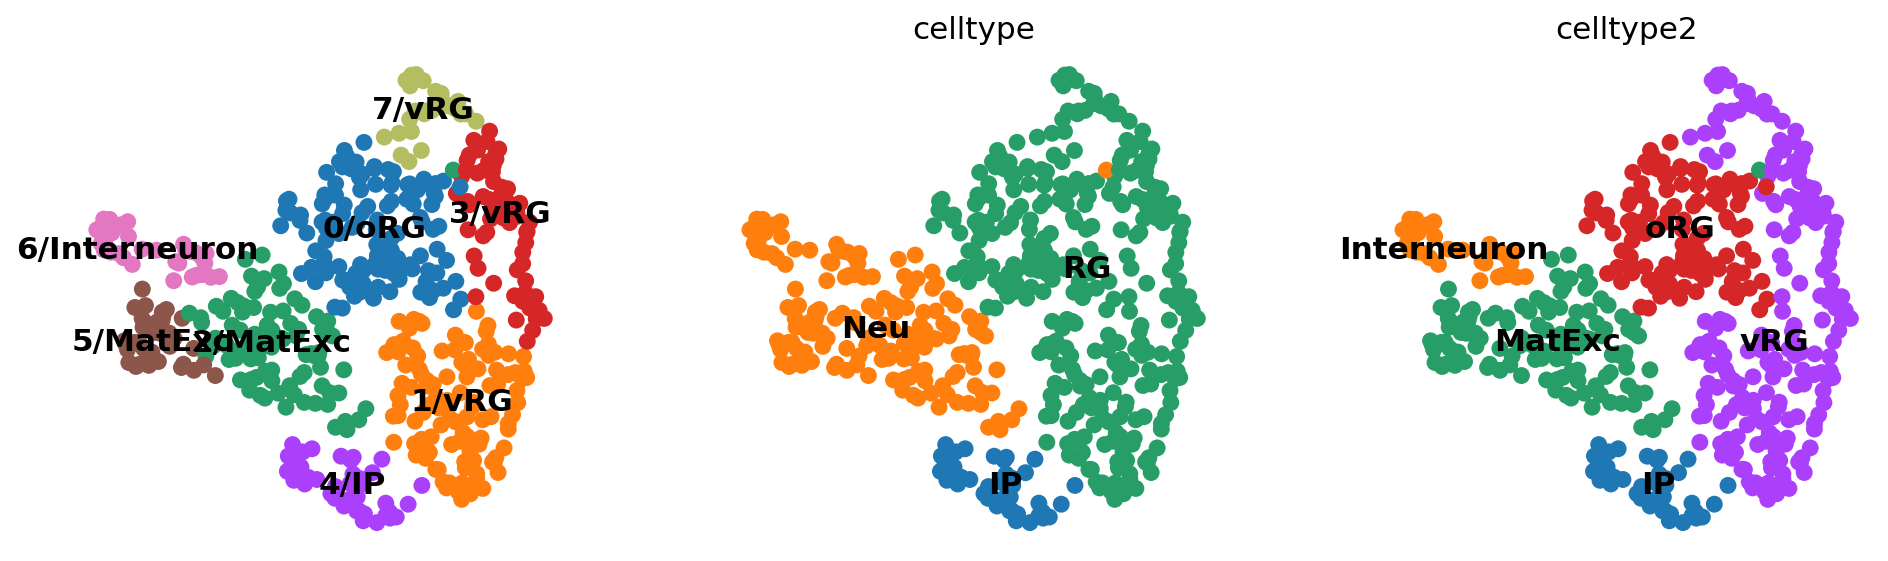

In [53]:
sc.pl.umap(adata, color=['leiden','celltype','celltype2'], legend_loc='on data', title='', frameon=False, save='.pdf')

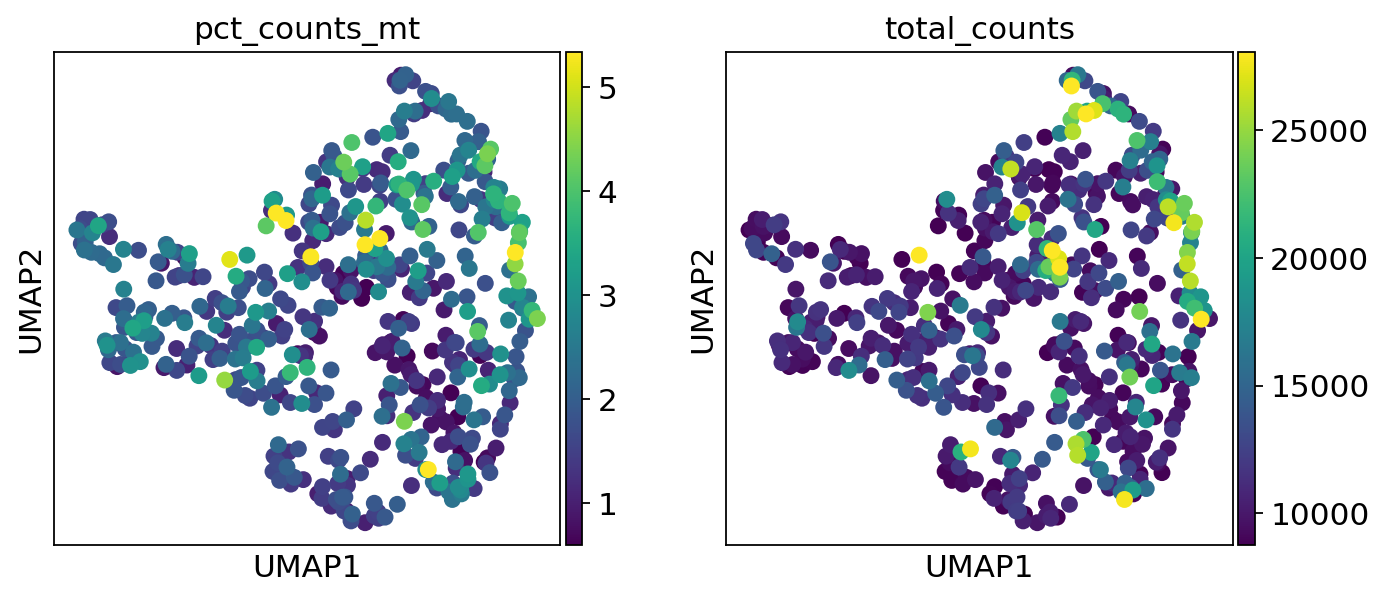

In [54]:
sc.pl.umap(adata,color=['pct_counts_mt','total_counts'],vmin='p1',vmax='p99')

In [55]:
sc.tl.dendrogram(adata,"leiden")


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


In [56]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9850708  0.9742822  0.9554046  0.95011204 0.94743186
     0.93991303 0.92338544 0.91397285 0.90914667 0.89508355 0.89061564
     0.88131887 0.87250364 0.86077774]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


In [57]:
adata.obs.leiden.value_counts()

0/oRG            121
1/vRG            111
2/MatExc          87
3/vRG             62
4/IP              40
5/MatExc          37
6/Interneuron     34
7/vRG             27
Name: leiden, dtype: int64

In [58]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9850708  0.9742822  0.9554046  0.95011204 0.94743186
     0.93991303 0.92338544 0.91397285 0.90914667 0.89508355 0.89061564
     0.88131887 0.87250364 0.86077774]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


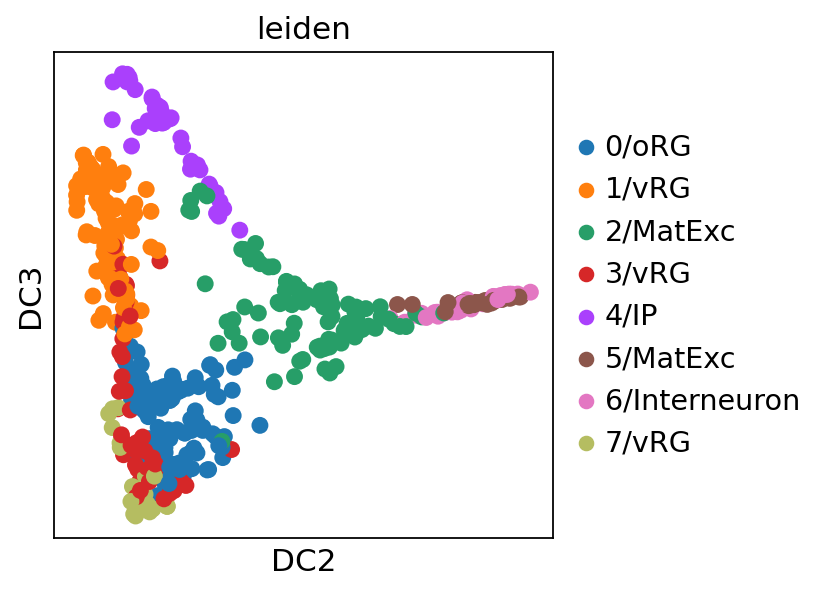

In [59]:
# no adata_check bcs no endo, pery... 
sc.pl.diffmap(adata,color="leiden",dimensions=(1,2))

In [60]:
adata.obs.leiden

AAACGGGCATCAGTCA-1       1/vRG
AAACGGGGTAAGTGTA-1       3/vRG
AAAGATGGTCAAGCGA-1       3/vRG
AAAGTAGAGAAGGTGA-1       1/vRG
AACACGTGTTCGGGCT-1    5/MatExc
                        ...   
TTGGCAATCCGCTGTT-1       1/vRG
TTGGCAATCTGGTGTA-1       3/vRG
TTGTAGGAGTAATCCC-1       1/vRG
TTGTAGGCACTGTTAG-1       0/oRG
TTTATGCCAGCGATCC-1       3/vRG
Name: leiden, Length: 519, dtype: category
Categories (8, object): ['0/oRG', '1/vRG', '2/MatExc', '3/vRG', '4/IP', '5/MatExc', '6/Interneuron', '7/vRG']

In [ ]:
adata.write_h5ad("/group/testa/Project/CBOProgPools/h5ad/CS22_02_20240208_v1.h5ad")

In [63]:
adata=sc.read_h5ad("/group/testa/Project/CBOProgPools/h5ad/CS22_02_20240208_v1.h5ad")

In [64]:
adata.obs['stage'] = 'CS22'

In [65]:
adata.write_h5ad('/group/testa/Project/CBOProgPools/h5ad/CS22_02_20240208_v1.h5ad')